In [1]:
import pandas as pd
import json
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
from itertools import chain
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# from nltk stopwords: https://gist.github.com/sebleier/554280
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [3]:
df_uniq_longlat = pd.read_json('locations_zika_2016.json') #dataframe with unique location per row

# First, plot the data on a map

In [4]:
def draw_map(m, scale=0.2):
    """
    Code to draw on map in python. Taken from
    https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html"""
    m.shadedrelief(scale=scale)
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

In [5]:
long, lat = df_uniq_longlat['longitude'].values,df_uniq_longlat['latitude'].values
long_lat = df_uniq_longlat[['longitude','latitude']].values

In [6]:
long_lat.shape # unique number of lat/long points

(664, 2)

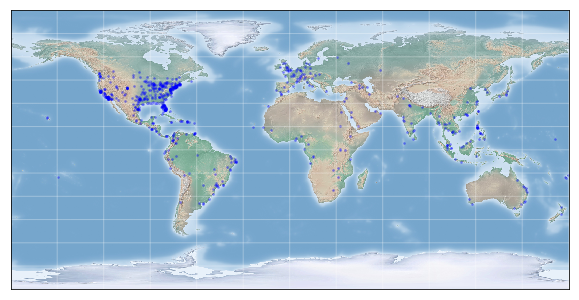

In [7]:
fig = plt.figure(figsize=(10, 8), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)

x, y = m(long, lat)
m.scatter(x,y,3,marker='o',color='b',alpha=0.3)
plt.show()

# Now, cluster and display the data
- use elbow method
- use unique lat/long

In [8]:
def get_kmeans_inertia_range(long_lat_data,max_clusters=10):
    inertia = {}
    for num_clusters in range(1,max_clusters):
        kmeans = KMeans(n_clusters=num_clusters,random_state=42).fit(long_lat_data)
        inertia[num_clusters] = kmeans.inertia_
    return inertia


In [9]:
inertia = get_kmeans_inertia_range(long_lat,max_clusters=50)

In [10]:
def plot_interia(log=False):
    fig, ax = plt.subplots()
    if log == True:
        ax.plot(inertia.keys(),np.log(list(inertia.values())))
        ax.set_ylabel('log(inertia)',fontsize=16)
        ax.vlines(x=11,ymin=0,ymax=15,linestyle='--')
    else:
        ax.plot(inertia.keys(),inertia.values())
        ax.set_ylabel('inertia',fontsize=16)
        ax.vlines(x=11,ymin=-10000,ymax=4200000,linestyle='--')
    #ax.vlines(x=11,ymin=0,ymax=15)
    ax.set_xlabel('num clusters',fontsize=16)
    plt.show()

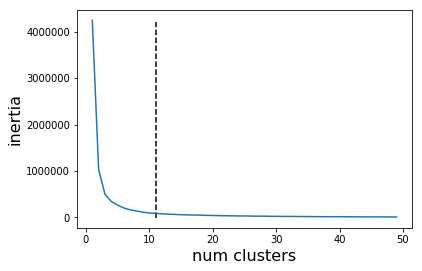

In [11]:
plot_interia()

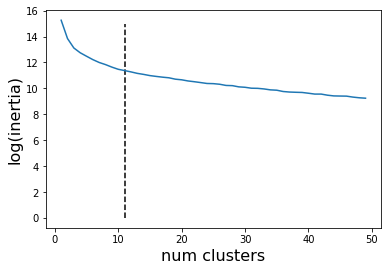

In [12]:
plot_interia(log=True)

choose 11 clusters because of domain knowledge. E.g., Florida != NYC and Brazil != Peru

### plot the clusters

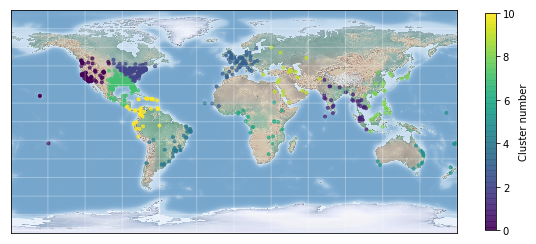

In [13]:
kmeans = KMeans(n_clusters=11,random_state=42).fit(long_lat)
df_uniq_longlat['cluster'] = kmeans.labels_

fig = plt.figure(figsize=(10, 8), edgecolor='w')
draw_map(m)
x, y = m(long_lat[:,0],long_lat[:,1])
m.scatter(x,y,9,marker='o',c=df_uniq_longlat['cluster'].values,alpha=0.7)
plt.colorbar(label='Cluster number',shrink=0.5);
plt.show()

### Before going on, extract all articles within a lat/long and flatten the data

In [14]:
date = []
topic = []
id = []
title = []
lat = []
long = []
cluster = []
for ix, article_chunk in enumerate(df_uniq_longlat['articles']):
    for article in article_chunk:
        try:
            date += [article['date']]
        except:
            date += [None]
        try:
            topic += [article['topic']]
        except:
            topic += [None]
        try:
            id += [article['id']]
        except:
            id += [None]
        try:
            title += [article['title']]
        except:
            title += [None]
        lat += [df_uniq_longlat.iloc[ix]['latitude']]
        long += [df_uniq_longlat.iloc[ix]['longitude']]
        cluster += [df_uniq_longlat.iloc[ix]['cluster']]

In [15]:
df_all = pd.DataFrame({'date':pd.to_datetime(date,infer_datetime_format=True),
                       'topic':topic,
                       'id':id,
                       'title':title,
                       'latitude':lat,
                       'longitude':long,
                       'cluster':cluster})

Map topics to index number

In [16]:
topic_name_to_ix = {k:v for v,k in enumerate(set(df_all['topic'].values))}
ix_to_topic = {v: k for k,v in topic_name_to_ix.items()}

In [17]:
df_all['topic_ix'] = df_all.apply(lambda row: topic_name_to_ix[row['topic']],axis=1)

# Exploratory data analysis
#1 what bigrams are characteristic of certain topics?
#2 what is happening at the spikes?
#3 what is happening geographically with topics?

In [18]:
count_vec = CountVectorizer(stop_words=stopwords,ngram_range=(1,2),min_df=20,max_df=0.5)

In [19]:
# count the bigrams
bigrams = count_vec.fit_transform(df_all['title']).todense()
df_bigrams = pd.DataFrame(bigrams,columns=count_vec.get_feature_names())

In [20]:
# add time and cluster to bigram counts
df_bigrams['cluster'] = df_all['cluster']
df_bigrams['date'] = df_all['date']

In [21]:
# transform such that rors are bigram and columns are clusters
bigram_count_by_cluster = df_bigrams.drop('date',axis=1).groupby('cluster').sum().T
bigram_count_by_cluster['all'] = bigram_count_by_cluster.apply(lambda row: sum(row),axis=1)

In [22]:
# Normalize so each cluster sums to one
bigram_freq_by_cluster = bigram_count_by_cluster.apply(lambda x: x/sum(x))

In [23]:
# compute normalized frequency
normed_bigram_freq_cluster = bigram_freq_by_cluster.divide(bigram_freq_by_cluster['all'],axis=0)

In [24]:
def plot_top_bigrams(cluster_num):
    fig, ax = plt.subplots()
    normed_bigram_freq_cluster[cluster_num].sort_values(ascending=False)[0:10].plot(kind='bar',color='royalblue',ax=ax)
    ax.set_ylabel('normalized bigram freq',fontsize=16)
    ax.set_title('Cluster '+str(cluster_num)+' top bigrams',fontsize=24)
    plt.show()

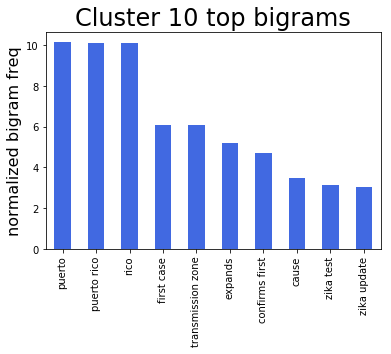

In [25]:
plot_top_bigrams(10)

plot dynamics of all articles

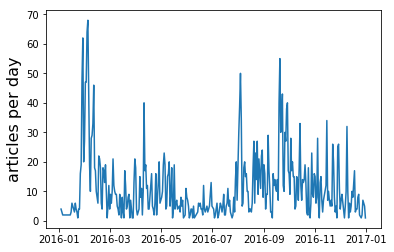

In [26]:
fig, ax = plt.subplots()
ax.plot(df_all[['date','id']].groupby('date').count())
ax.set_ylabel('articles per day',fontsize=16)
plt.show()

In [27]:
#df_cluster_time = df_all[['date','id','cluster']].groupby(['date','cluster']).count().reset_index().set_index('date')

In [28]:
#df_cluster_topic = df_all[['date','id','topic_ix']].groupby(['date','topic_ix']).count().reset_index().set_index('date')

In [114]:
#ix_to_topic = {v: k for k,v in topic_name_to_ix.items()}

In [28]:
#cluster_counts = {k:v for k,v in enumerate(df_all.groupby('cluster').count().iloc[:,0])}

In [38]:
#df_all[['date','id']].groupby('date').count().sort_values('id',ascending=False)[0:5].plot(kind='bar')

### Explore bigrams in dates with most articles

In [29]:
df_all.groupby('date').count().sort_values('id',ascending=False)['id'].head(20)

date
2016-02-04    68
2016-02-03    64
2016-01-29    62
2016-09-20    55
2016-08-04    50
2016-01-28    48
2016-02-02    47
2016-02-01    47
2016-02-11    46
2016-02-05    45
2016-09-23    43
2016-04-11    40
2016-09-29    40
2016-09-19    40
2016-08-03    39
2016-09-28    38
2016-09-22    35
2016-08-05    34
2016-11-15    34
2016-10-14    33
Name: id, dtype: int64

In [30]:
# get data of bigram counts per day
bigram_by_date = df_bigrams.drop('cluster',axis=1).groupby('date').sum().T
bigram_by_date['all'] = bigram_by_date.apply(lambda row: np.sum(row),axis=1)

In [31]:
# normalize so each day sums to one
normed_bigram_by_date = bigram_by_date.apply(lambda col: col/np.sum(col))
normed_bigram_by_date.fillna(0,inplace=True)

In [32]:
# compute normalized frequency for each date
normed_bigram_freq_date = normed_bigram_by_date.divide(normed_bigram_by_date['all'],axis=0)
normed_bigram_freq_date.columns = [str(ix).split(' ')[0] for ix in normed_bigram_freq_date.columns]

In [33]:
def plot_top_bigrams(date):
    fig, ax = plt.subplots()

    normed_bigram_freq_date.sort_values(date,ascending=False)[date][0:10].plot(kind='bar',color='royalblue',ax=ax)
    ax.set_ylabel('normalized bigram freq',fontsize=16)
    ax.set_title('Top bigrams '+str(date),fontsize=24)
    plt.show()

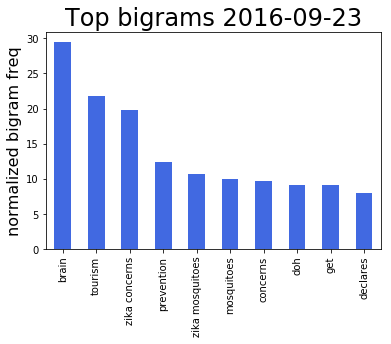

In [34]:
plot_top_bigrams('2016-09-23')

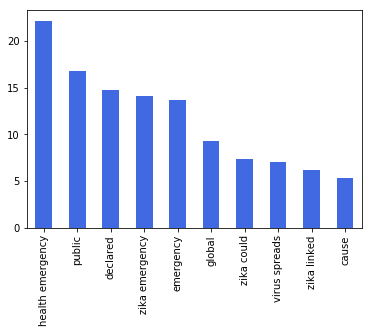

In [35]:
normed_bigram_freq_date.sort_values('2016-02-01',ascending=False)['2016-02-01'][0:10].plot(kind='bar',color='royalblue')

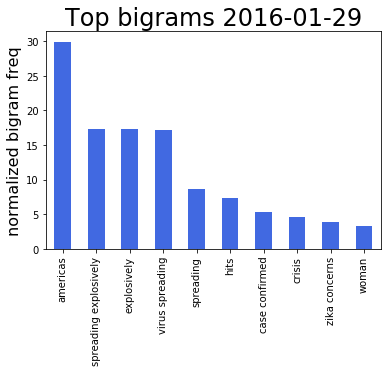

In [36]:
plot_top_bigrams('2016-01-29')

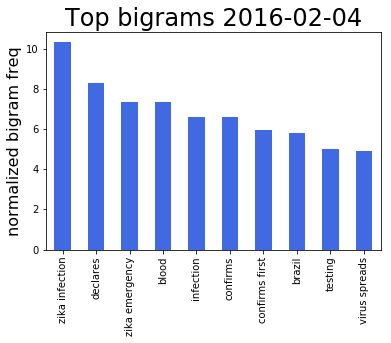

In [37]:
plot_top_bigrams('2016-02-04')

# Further exploration

In [38]:
# Find the topics with the most articles and explore these
df_all.groupby('topic_ix').count().sort_values('id',ascending=False)['id'].head()

topic_ix
88    611
47    343
28    172
73    160
65    152
Name: id, dtype: int64

Topics have varying time profiles

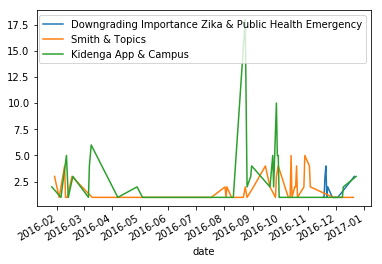

In [39]:
fig, ax = plt.subplots()

df_cluster_topic = df_all[['date','id','topic_ix']].groupby(['date','topic_ix']).count().reset_index().set_index('date')
df_cluster_topic[df_cluster_topic['topic_ix']==59]['id'].plot(label=ix_to_topic[59],ax=ax)
df_cluster_topic[df_cluster_topic['topic_ix']==77]['id'].plot(label=ix_to_topic[67],ax=ax)
df_cluster_topic[df_cluster_topic['topic_ix']==82]['id'].plot(label=ix_to_topic[84],ax=ax)
ax.legend()
plt.show()

clusters have varying time profiles

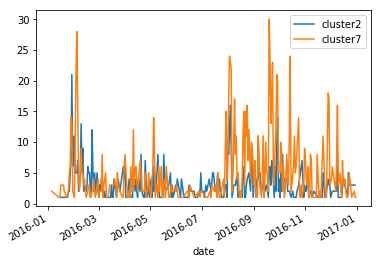

In [40]:
fig, ax = plt.subplots()
df_cluster_time = df_all[['date','id','cluster']].groupby(['date','cluster']).count().reset_index().set_index('date')
df_cluster_time[df_cluster_time['cluster']==2]['id'].plot(label='cluster2',ax=ax)
df_cluster_time[df_cluster_time['cluster']==7]['id'].plot(label='cluster7',ax=ax)
plt.legend()
plt.show()